### Install and Import Dependencies

In [76]:
# Install the necessary packages
%pip install pandas
%pip install scipy
%pip install matplotlib
%pip install seaborn
%pip install scikit-learn
%pip install numpy
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [77]:
# Importing packages

# For loading, processing, and displaying data
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
# For Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
# For evaluating Classifier
from sklearn import metrics
# For Random Upsampling
from sklearn.utils import resample
# For SMOTE and Borderline SMOTE
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE

### Load Dataset

In [78]:
# Dataset downloaded from: https://archive.ics.uci.edu/dataset/266/seismic+bumps
# Load in the arff file
# Scipy Documentation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.arff.loadarff.html
arff_file = arff.loadarff('data/seismic-bumps.arff')

# Convert to a pandas dataframe
data = pd.DataFrame(arff_file[0])

### Explore Dataset

In [79]:
# Get shape of dataframe: (rows, columns)
print("Shape of dataframe (rows, columns): ", data.shape)

Shape of dataframe (rows, columns):  (2584, 19)


In [80]:
# Peek into the dataframe
data.sample(5)

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
989,b'a',b'a',b'N',5170.0,19.0,-27.0,-52.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'
1589,b'a',b'b',b'N',12300.0,424.0,34.0,39.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'
2450,b'a',b'a',b'W',7870.0,141.0,-71.0,-67.0,b'a',1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,700.0,700.0,b'0'
873,b'a',b'a',b'W',101050.0,213.0,-8.0,9.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'
1533,b'b',b'b',b'W',65800.0,1634.0,300.0,255.0,b'b',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'


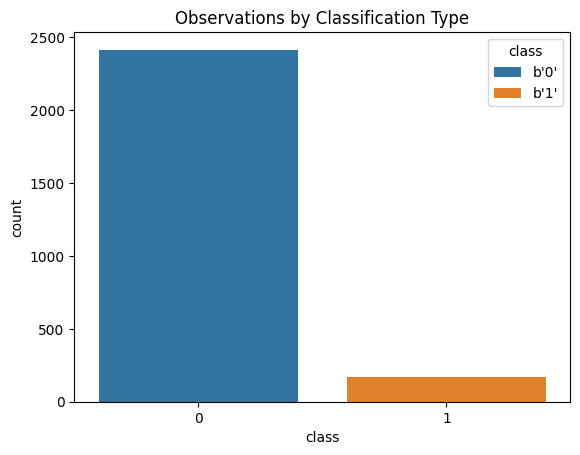

In [81]:
# Seaborn countplot documentation: https://seaborn.pydata.org/generated/seaborn.countplot.html
# Create a bar chart to plot counts of each class
ax = sns.countplot(x = data['class'], hue=data['class'])

# Add plot title
plt.title("Observations by Classification Type")

# show plot
plt.show()

### Process/Split Dataset

In [82]:
# Get only the numerical data columns
input_cols = [i for i in range(data.shape[1]) if i not in ([0, 1, 2, 7, 18])]

# Split into input, X, and output, Y
X = data.iloc[:,input_cols]
Y = data.iloc[:,-1].astype(np.float32)

In [83]:
# Get the shape of each
print("Shape of X: ", X.shape)
print("Shape of Y: ", Y.shape)

# Peek into each dataframe
display(X.head(5))
display(Y.head(5))

Shape of X:  (2584, 14)
Shape of Y:  (2584,)


,genergy,gpuls,gdenergy,gdpuls,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy
0,15180.0,48.0,-72.0,-72.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,14720.0,33.0,-70.0,-79.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2000.0,2000.0
2,8050.0,30.0,-81.0,-78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,28820.0,171.0,-23.0,40.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3000.0,3000.0
4,12640.0,57.0,-63.0,-52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: class, dtype: float32

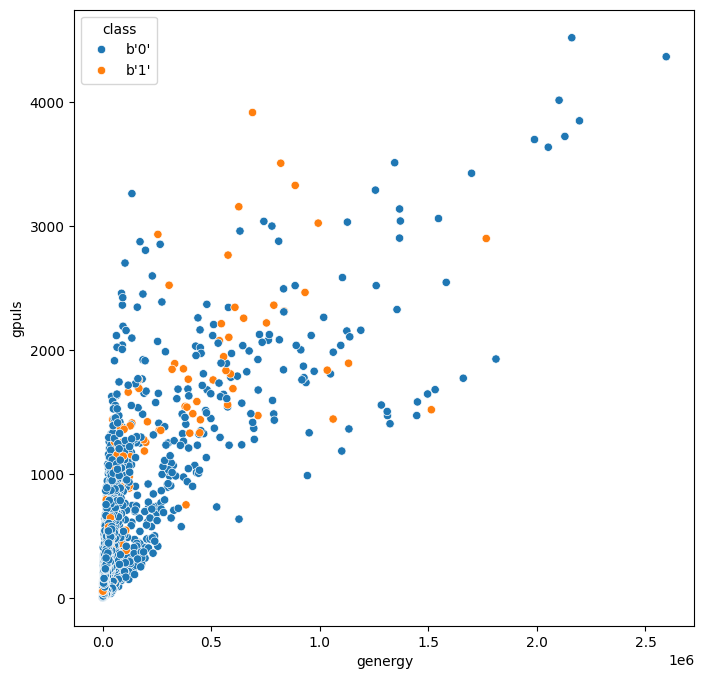

In [114]:
# Plot some features of the input data with the majority and minority class labels
# Seaborn Scatterplot documentation: https://seaborn.pydata.org/generated/seaborn.scatterplot.html
plt.figure(figsize=(8, 8))
ax = sns.scatterplot(data=data, x='genergy', y='gpuls', hue='class')
plt.show()

In [85]:
# Split the data into the train and test set
# Scikitlearn train_test_split documentation: 
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

### Random Forest Scikit-learn

### Baseline Model

In [86]:
# Make the classifier. Use default values except the random_state, 
# which sets the seed for the randomness in bootstrapping the data for each decision tree
# Sklearn Random Forest documentation: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
baseline_classifier = RandomForestClassifier(random_state=0)

# FIt the classifier to the data
baseline_classifier.fit(X_train, Y_train)

RandomForestClassifier(random_state=0)

### Evaluation with Performance Metrics

In [87]:
# Running the test set through the model
# This function outputs the probability for each class
baseline_output = baseline_classifier.predict_proba(X_test)

# Peek into a few predicted output probabilities: (probability of class 0, probability of class 1)
print(baseline_output[:5])

# Grab the predicted probabilities for class 1 (We treat this as the positive, minority class)
y_class1_pred_prob = baseline_output[:, 1]

[[0.86 0.14]
 [0.98 0.02]
 [1.   0.  ]
 [0.78 0.22]
 [1.   0.  ]]


In [88]:
# Getting the False Positive and True Positive rates for later comparison
# Sklearn roc_curve documentation: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
baseline_fpr, baseline_tpr, _ = metrics.roc_curve(Y_test, y_class1_pred_prob, pos_label=1) # pos_label specifies which class is the positive class

# Finding the AUC score for later comparison
# Sklearn auc documentation: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html
baseline_roc_auc = metrics.auc(baseline_fpr, baseline_tpr)

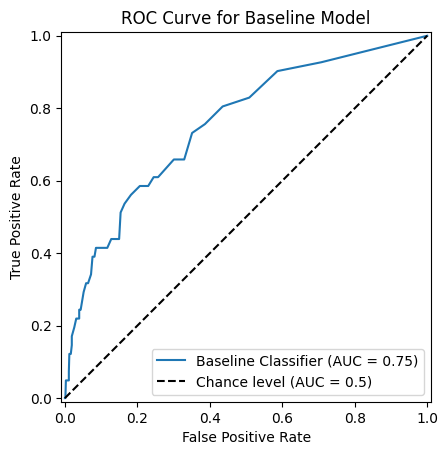

In [89]:
# Plotting the ROC curve
# Sklearn RocCurveDisplay documentation: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html
baseline_display_roc = metrics.RocCurveDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob, 
    pos_label=1, # Specify that class 1 is the positive class
    name='Baseline Classifier', 
    plot_chance_level=True # Plots the ROC curve for a random classifier
)

# Labeling and titling the plot
plt.title("ROC Curve for Baseline Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [90]:
# Get precision recall on the test set for later comparison
# Sklearn precision_recall_curve: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html
baseline_precision, baseline_recall, _ = metrics.precision_recall_curve(Y_test, y_class1_pred_prob)

# Getting the AUC for later comparison
baseline_pr_auc = metrics.auc(baseline_recall, baseline_precision)

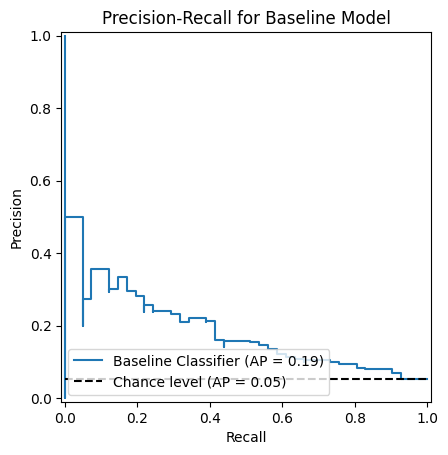

In [91]:
# Plotting the P-R Curve
# Sklearn PrecisionRecallDisplay documentation: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html
baseline_display_pr = metrics.PrecisionRecallDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob,
    pos_label = 1,
    name = "Baseline Classifier",
    plot_chance_level=True # Plots the PR curve of a random classifier
)

# Labeling the plot
plt.title("Precision-Recall for Baseline Model")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

## Upsampling Techniques

### Random Upsampling

In [92]:
# Randomly upsample the data, then split again
# Imblearn Documentation: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html#imblearn.over_sampling.RandomOverSampler
tmpx, tmpy = RandomOverSampler(random_state=0).fit_resample(X, Y)
X_train_randup, _, Y_train_randup, _ = train_test_split(tmpx, tmpy, test_size=0.3, random_state=0)

In [119]:
# Comparison of dataset sizes
counter = Counter(Y_train)
total = counter[0] + counter[1]
print('Before using Random Upsampling')
print('Number of data points in class 0:  ', counter[0])
print('Number of data points in class 1: ', counter[1])
print('Class 0: ', round(counter[0] / total * 100, 2), 
			'%, Class 1: ', round(counter[1] / total * 100, 2), '%\n')

counter = Counter(Y_train_randup)
total = counter[0] + counter[1]
print('After using Random Upsampling')
print('Number of data points in class 0:  ', counter[0])
print('Number of data points in class 1: ', counter[1])
print('Class 0: ', round(counter[0] / total * 100, 2), 
			'%, Class 1: ', round(counter[1] / total * 100, 2), '%')

Before using Random Upsampling
Number of data points in class 0:   1679
Number of data points in class 1:  129
Class 0:  92.87 %, Class 1:  7.13 %

After using Random Upsampling
Number of data points in class 0:   1688
Number of data points in class 1:  1691
Class 0:  49.96 %, Class 1:  50.04 %


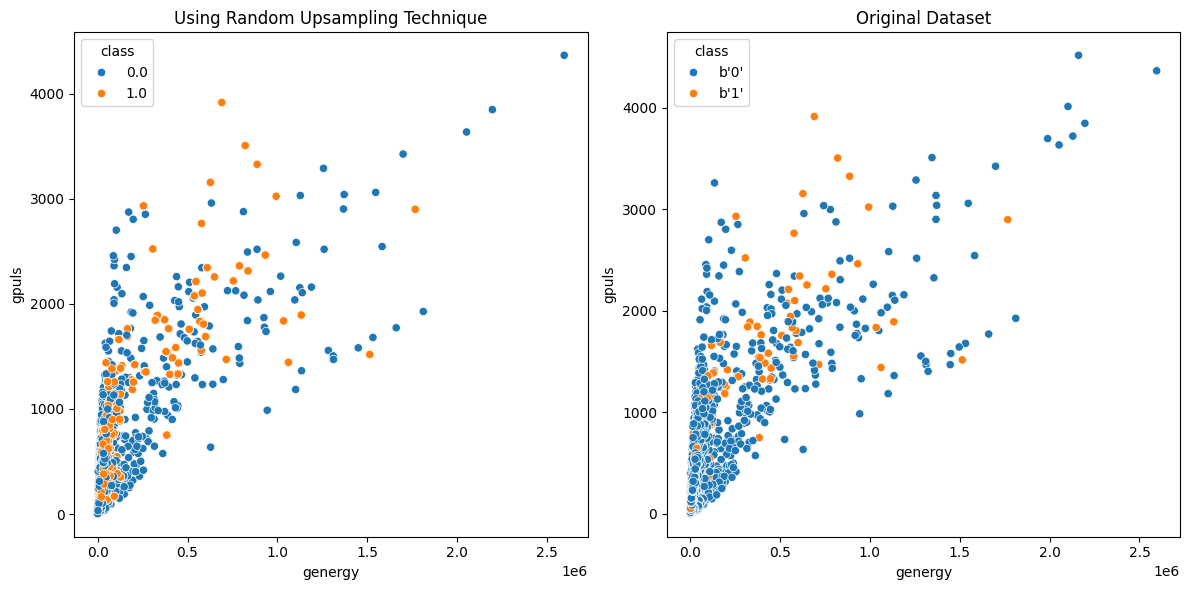

In [94]:
# Plot the new data
randup_df = pd.concat([X_train_randup, Y_train_randup], axis=1)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.scatterplot(data=randup_df, x='genergy', y='gpuls', hue='class', ax=axes[0])
axes[0].set_title('Using Random Upsampling Technique')
sns.scatterplot(data=data, x='genergy', y='gpuls', hue='class', ax=axes[1])
axes[1].set_title('Original Dataset')
plt.tight_layout()
plt.show()

In [95]:
# Building and fitting classifer to Random Upsampled data
randup_model = RandomForestClassifier(random_state=0)
randup_model.fit(X_train_randup, Y_train_randup)
randup_output = randup_model.predict_proba(X_test)
y_class1_pred_prob_randup = randup_output[:, 1]

In [96]:
# Get metrics: False Positive Rate, True Positive Rate, Precision, and Recall
randup_fpr, randup_tpr, _ = metrics.roc_curve(Y_test, y_class1_pred_prob_randup, pos_label=1)
randup_roc_auc = metrics.auc(randup_fpr, randup_tpr)
randup_precision, randup_recall, _ = metrics.precision_recall_curve(Y_test, y_class1_pred_prob_randup)
randup_pr_auc = metrics.auc(randup_recall, randup_precision)

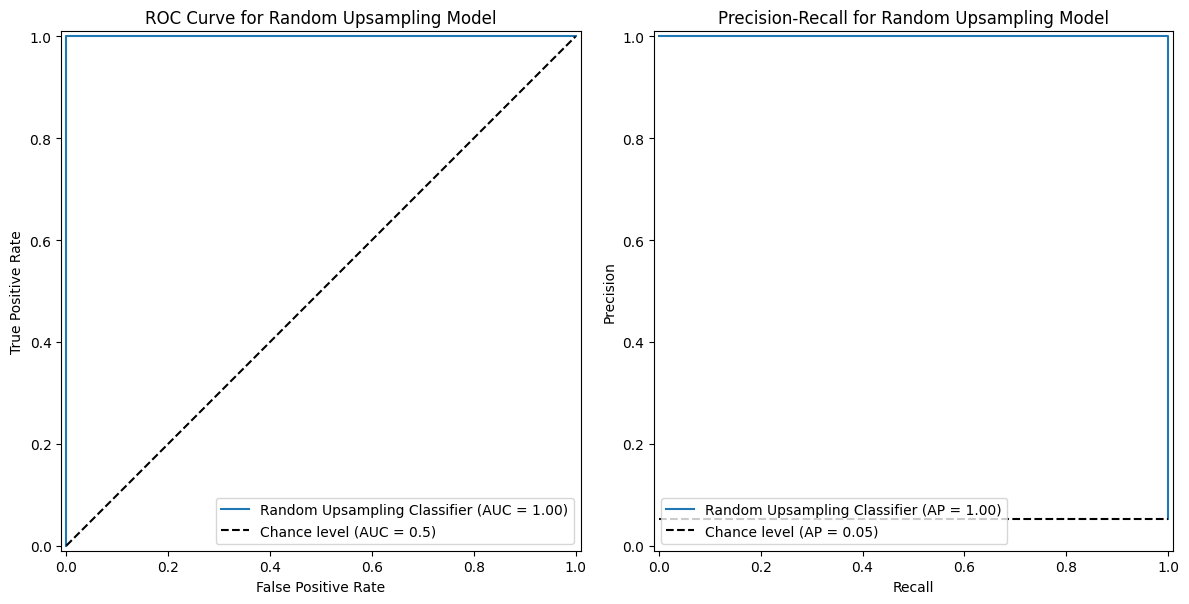

In [97]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the ROC Curve
metrics.RocCurveDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob_randup, 
    pos_label=1,
    name='Random Upsampling Classifier', 
    plot_chance_level=True,
    ax=axes[0]
)
axes[0].set_title("ROC Curve for Random Upsampling Model")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")

# Plot the Precision-Recall curve
metrics.PrecisionRecallDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob_randup,
    pos_label = 1,
    name = "Random Upsampling Classifier",
    plot_chance_level=True,
    ax=axes[1]
)
axes[1].set_title("Precision-Recall for Random Upsampling Model")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")

# Adjust layout and display
plt.tight_layout()
plt.show()

### SMOTE

In [98]:
# Applying SMOTE to the training data
# Imblearn SMOTE documentation: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
tmpx, tmpy = SMOTE(random_state=0).fit_resample(X, Y)
X_train_SMOTE, _, Y_train_SMOTE, _ = train_test_split(tmpx, tmpy, test_size=0.3, random_state=0)

In [120]:
# Comparison of dataset sizes
counter = Counter(Y_train)
total = counter[0] + counter[1]
print('Before using SMOTE')
print('Number of data points in class 0:  ', counter[0])
print('Number of data points in class 1: ', counter[1])
print('Class 0: ', round(counter[0] / total * 100, 2), '%, Class 1: ', round(counter[1] / total * 100, 2), '%\n')

counter = Counter(Y_train_SMOTE)
total = counter[0] + counter[1]
print('After Using SMOTE')
print('Number of data points in class 0:  ', counter[0])
print('Number of data points in class 1: ', counter[1])
print('Class 0: ', round(counter[0] / total * 100, 2), '%, Class 1: ', round(counter[1] / total * 100, 2), '%')

Before using SMOTE
Number of data points in class 0:   1679
Number of data points in class 1:  129
Class 0:  92.87 %, Class 1:  7.13 %

After Using SMOTE
Number of data points in class 0:   1688
Number of data points in class 1:  1691
Class 0:  49.96 %, Class 1:  50.04 %


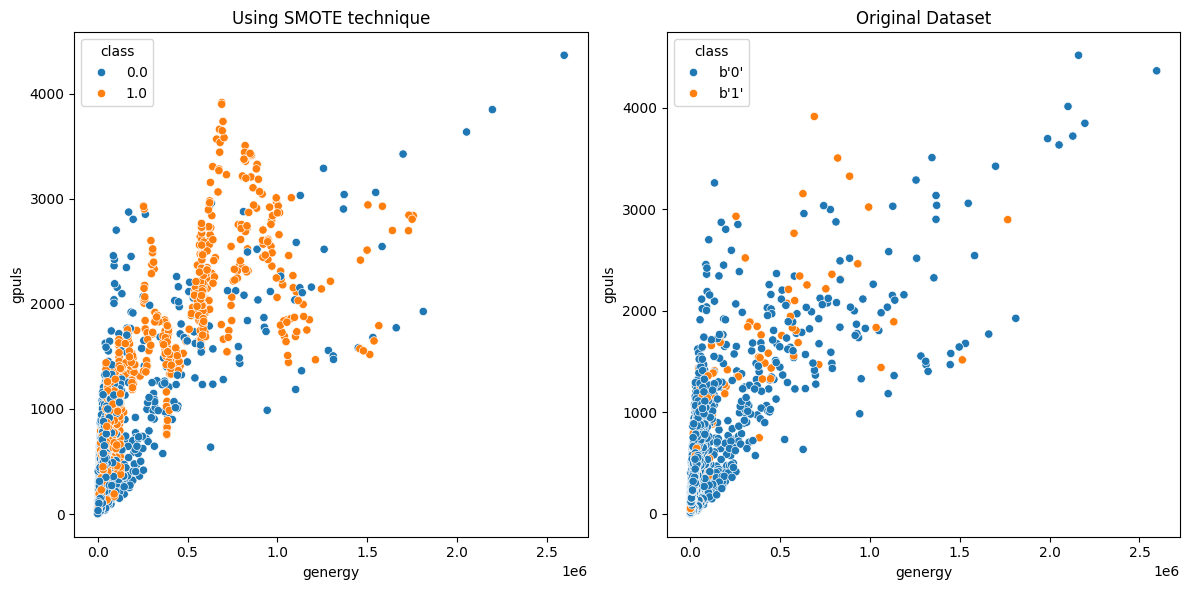

In [100]:
# Plot the new data
SMOTEDf = pd.concat([X_train_SMOTE, Y_train_SMOTE], axis=1)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.scatterplot(data=SMOTEDf, x='genergy', y='gpuls', hue='class', ax=axes[0])
axes[0].set_title('Using SMOTE technique')
sns.scatterplot(data=data, x='genergy', y='gpuls', hue='class', ax=axes[1])
axes[1].set_title('Original Dataset')
plt.tight_layout()
plt.show()

In [101]:
# Building and fitting the classifier to the SMOTE data
SMOTE_model = RandomForestClassifier(random_state=0)
SMOTE_model.fit(X_train_SMOTE, Y_train_SMOTE)
output = SMOTE_model.predict_proba(X_test)
y_class1_pred_prob_SMOTE = output[:, 1]

In [102]:
# Get metrics: False Positive Rate, True Positive Rate, Precision, and Recall
SMOTE_fpr, SMOTE_tpr, _ = metrics.roc_curve(Y_test, y_class1_pred_prob_SMOTE, pos_label=1)
SMOTE_roc_auc = metrics.auc(SMOTE_fpr, SMOTE_tpr)
SMOTE_precision, SMOTE_recall, _ = metrics.precision_recall_curve(Y_test, y_class1_pred_prob_SMOTE)
SMOTE_pr_auc = metrics.auc(SMOTE_recall, SMOTE_precision)

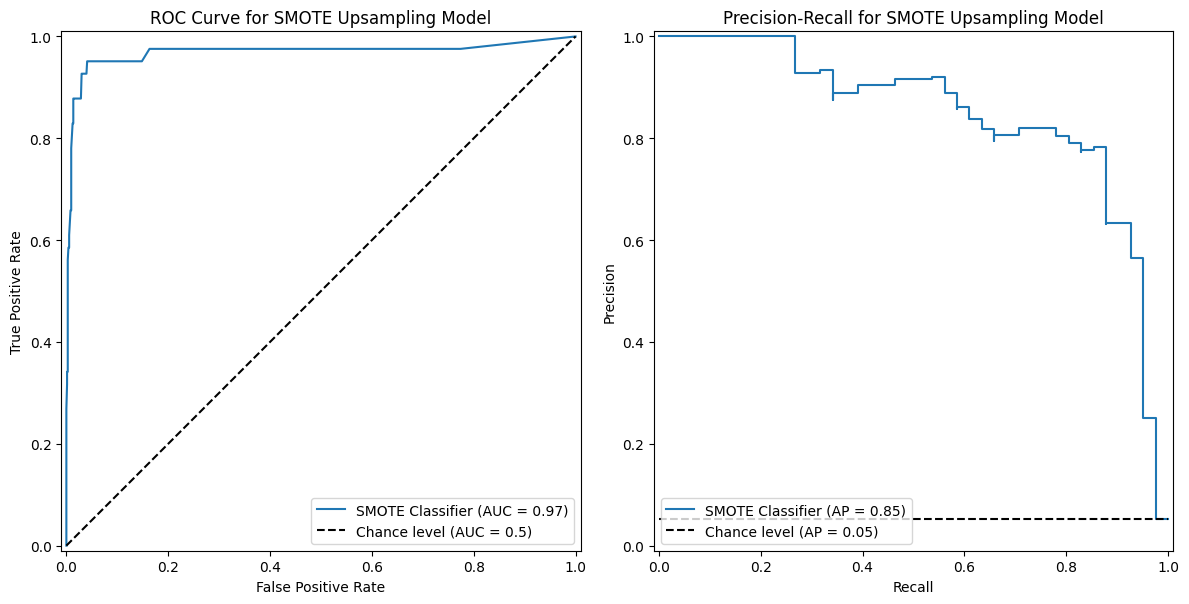

In [103]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the ROC Curve
metrics.RocCurveDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob_SMOTE, 
    pos_label=1,
    name='SMOTE Classifier', 
    plot_chance_level=True,
    ax=axes[0]
)
axes[0].set_title("ROC Curve for SMOTE Upsampling Model")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")

# Plot the Precision-Recall curve
metrics.PrecisionRecallDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob_SMOTE,
    pos_label = 1,
    name = "SMOTE Classifier",
    plot_chance_level=True,
    ax=axes[1]
)
axes[1].set_title("Precision-Recall for SMOTE Upsampling Model")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")

# Adjust layout and display
plt.tight_layout()
plt.show()

### Borderline SMOTE

In [104]:
# Applying Borderline SMOTE to the training data
# Imblearn Borderline SMOTE documentation: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.BorderlineSMOTE.html
tmpx, tmpy = BorderlineSMOTE(random_state=0).fit_resample(X, Y)
X_train_BordSMOTE, _, Y_train_BordSMOTE, _ = train_test_split(tmpx, tmpy, test_size=0.3, random_state=0)

In [121]:
# Comparison of dataset sizes
counter = Counter(Y_train)
total = counter[0] + counter[1]
print('Before using Borderline SMOTE')
print('Number of data points in class 0:  ', counter[0])
print('Number of data points in class 1: ', counter[1])
print('Class 0: ', round(counter[0] / total * 100, 2), '%, Class 1: ', round(counter[1] / total * 100, 2), '%\n')

counter = Counter(Y_train_BordSMOTE)
total = counter[0] + counter[1]
print('After Using Borderline SMOTE')
print('Number of data points in class 0:  ', counter[0])
print('Number of data points in class 1: ', counter[1])
print('Class 0: ', round(counter[0] / total * 100, 2), '%, Class 1: ', round(counter[1] / total * 100, 2), '%')

Before using Borderline SMOTE
Number of data points in class 0:   1679
Number of data points in class 1:  129
Class 0:  92.87 %, Class 1:  7.13 %

After Using Borderline SMOTE
Number of data points in class 0:   1688
Number of data points in class 1:  1691
Class 0:  49.96 %, Class 1:  50.04 %


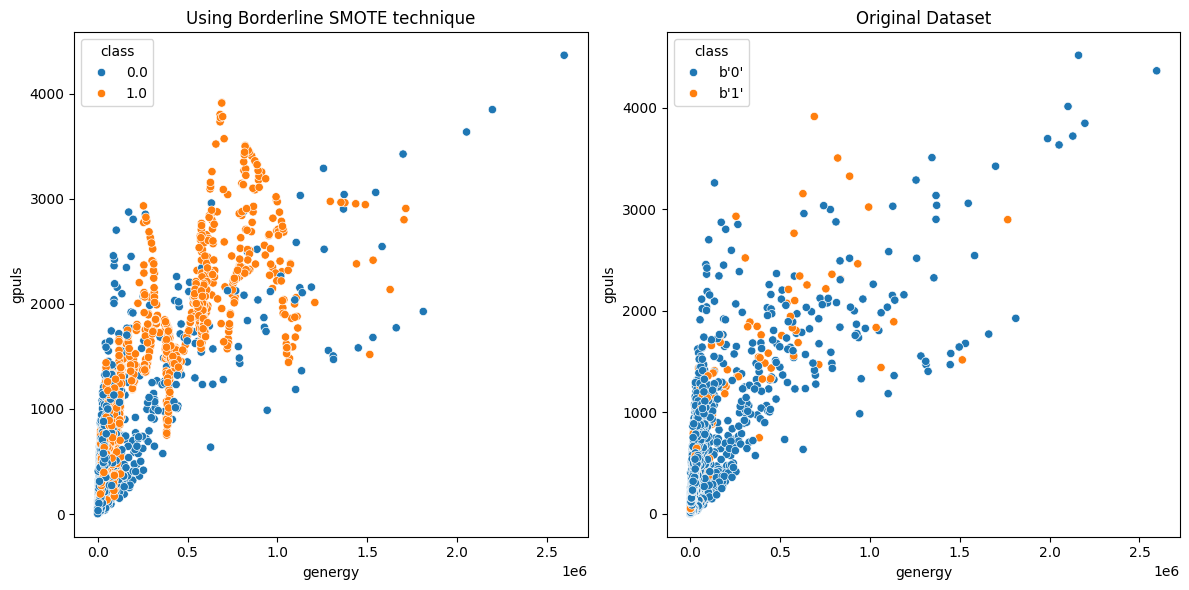

In [106]:
# Plot the new data
BordSMOTEDf = pd.concat([X_train_BordSMOTE, Y_train_BordSMOTE], axis=1)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.scatterplot(data=BordSMOTEDf, x='genergy', y='gpuls', hue='class', ax=axes[0])
axes[0].set_title('Using Borderline SMOTE technique')
sns.scatterplot(data=data, x='genergy', y='gpuls', hue='class', ax=axes[1])
axes[1].set_title('Original Dataset')
plt.tight_layout()
plt.show()

In [107]:
# Building and fitting the classifier to the Borderline SMOTE data
BordSMOTE_model = RandomForestClassifier(random_state=0)
BordSMOTE_model.fit(X_train_BordSMOTE, Y_train_BordSMOTE)
output = BordSMOTE_model.predict_proba(X_test)
y_class1_pred_prob_BordSMOTE = output[:, 1]

In [108]:
# Get metrics: False Positive Rate, True Positive Rate, Precision, and Recall
BordSMOTE_fpr, BordSMOTE_tpr, _ = metrics.roc_curve(Y_test, y_class1_pred_prob_BordSMOTE, pos_label=1)
BordSMOTE_roc_auc = metrics.auc(BordSMOTE_fpr, BordSMOTE_tpr)
BordSMOTE_precision, BordSMOTE_recall, _ = metrics.precision_recall_curve(Y_test, y_class1_pred_prob_BordSMOTE)
BordSMOTE_pr_auc = metrics.auc(BordSMOTE_recall, BordSMOTE_precision)

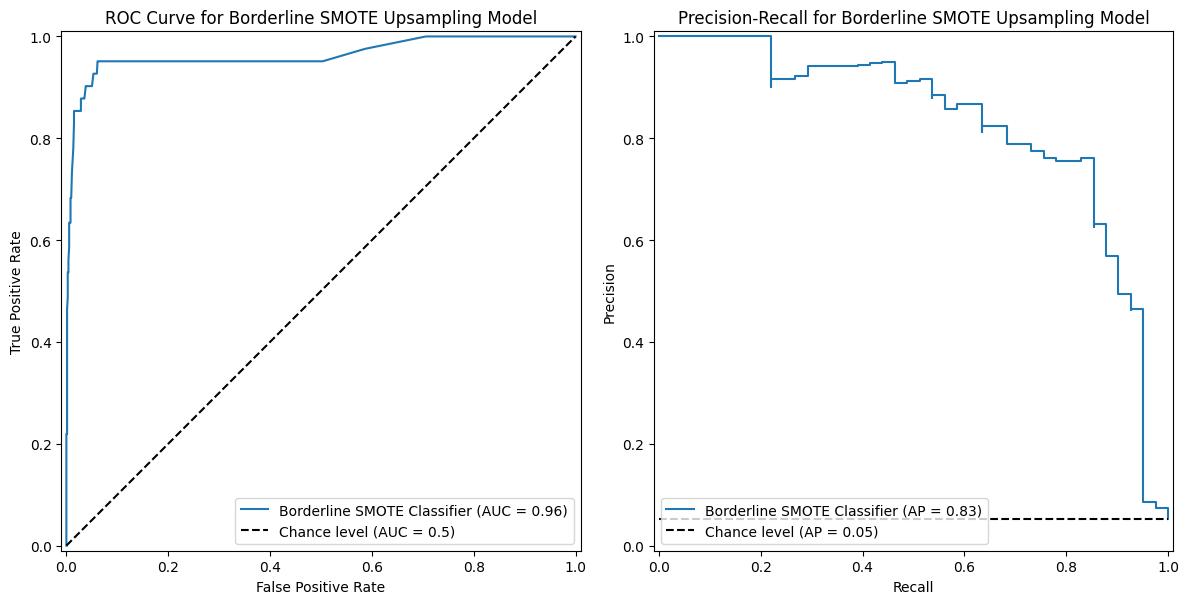

In [109]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the ROC Curve
metrics.RocCurveDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob_BordSMOTE, 
    pos_label=1,
    name='Borderline SMOTE Classifier', 
    plot_chance_level=True,
    ax=axes[0]
)
axes[0].set_title("ROC Curve for Borderline SMOTE Upsampling Model")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")

# Plot the Precision-Recall curve
metrics.PrecisionRecallDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob_BordSMOTE,
    pos_label = 1,
    name = "Borderline SMOTE Classifier",
    plot_chance_level=True,
    ax=axes[1]
)
axes[1].set_title("Precision-Recall for Borderline SMOTE Upsampling Model")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")

# Adjust layout and display
plt.tight_layout()
plt.show()

# Comparisons

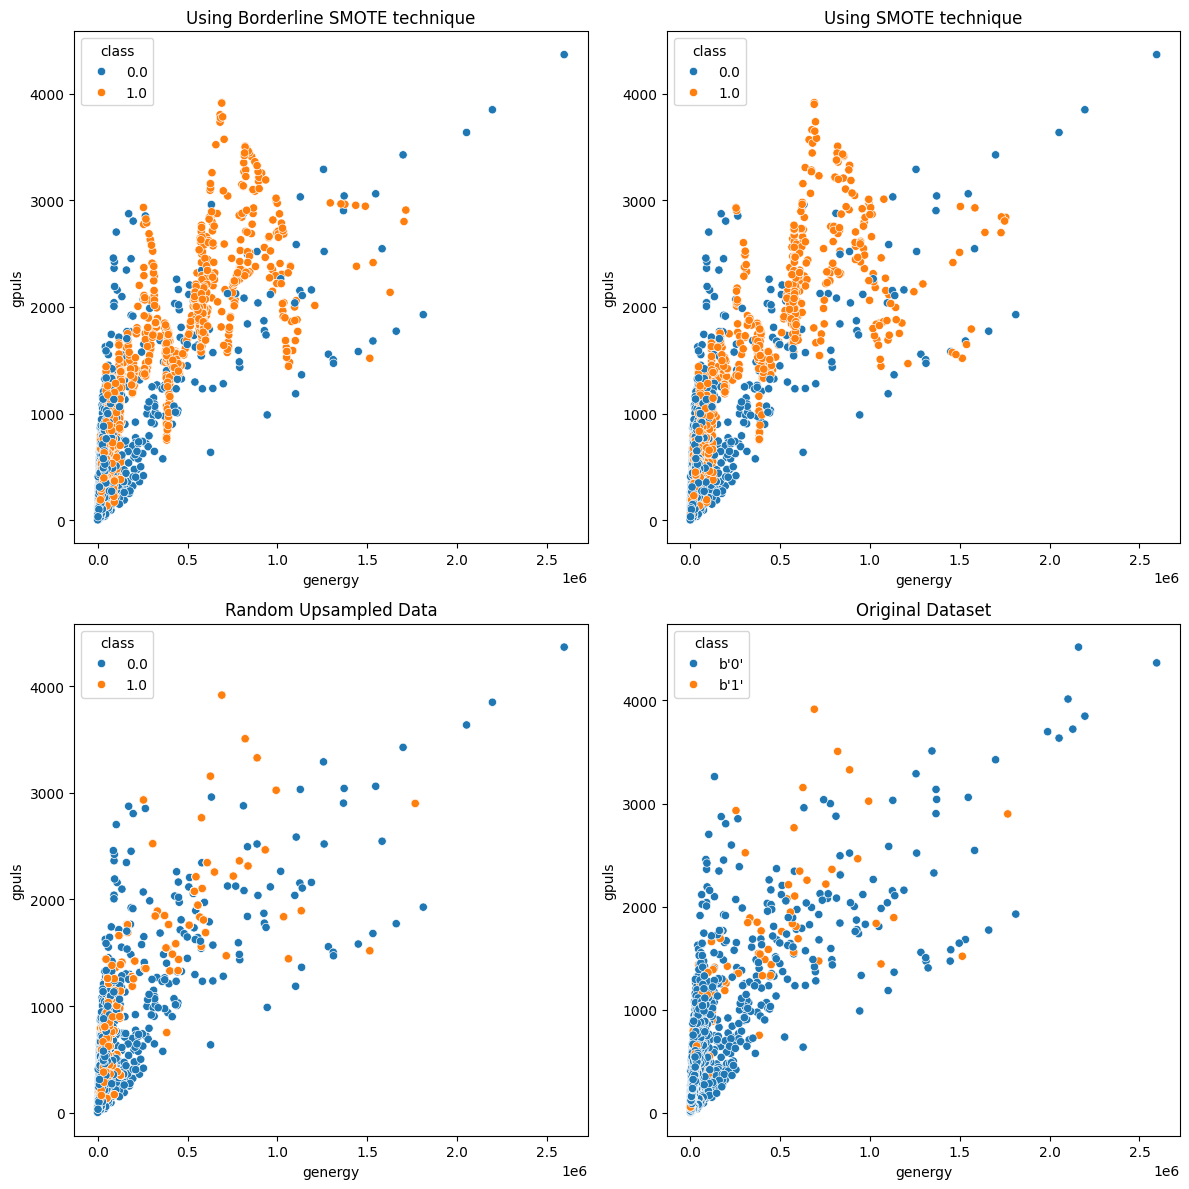

In [110]:
# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Plot using Borderline SMOTE technique
sns.scatterplot(data=BordSMOTEDf, x='genergy', y='gpuls', hue='class', ax=axes[0, 0])
axes[0, 0].set_title('Using Borderline SMOTE technique')

# Plot using SMOTE technique
sns.scatterplot(data=SMOTEDf, x='genergy', y='gpuls', hue='class', ax=axes[0, 1])
axes[0, 1].set_title('Using SMOTE technique')

# Plot using Random Upsampled Data
sns.scatterplot(data=randup_df, x='genergy', y='gpuls', hue='class', ax=axes[1, 0])
axes[1, 0].set_title('Random Upsampled Data')

# Plot the original dataset
sns.scatterplot(data=data, x='genergy', y='gpuls', hue='class', ax=axes[1, 1])
axes[1, 1].set_title('Original Dataset')

plt.tight_layout()
plt.show()

In [111]:
# Printing out the collected ROC-AUC scores
print("ROC-AUC\n" + "=" * 20)
print(f"Baseline: {baseline_roc_auc}\n\
Random Upsampling: {randup_roc_auc}\n\
SMOTE: {SMOTE_roc_auc}\n\
Borderline-SMOTE: {BordSMOTE_roc_auc}")

print()

# Printing out the collected PR-AUC scores
print("PR-AUC\n" + "=" * 20)
print(f"Baseline: {baseline_pr_auc}\n\
Random Upsampling: {randup_pr_auc}\n\
SMOTE: {SMOTE_pr_auc}\n\
Borderline-SMOTE: {BordSMOTE_pr_auc}")

ROC-AUC
Baseline: 0.7548863447818152
Random Upsampling: 1.0
SMOTE: 0.9685913389746142
Borderline-SMOTE: 0.9630662020905922

PR-AUC
Baseline: 0.17051578025754688
Random Upsampling: 1.0
SMOTE: 0.8477822780553932
Borderline-SMOTE: 0.8273125989909071


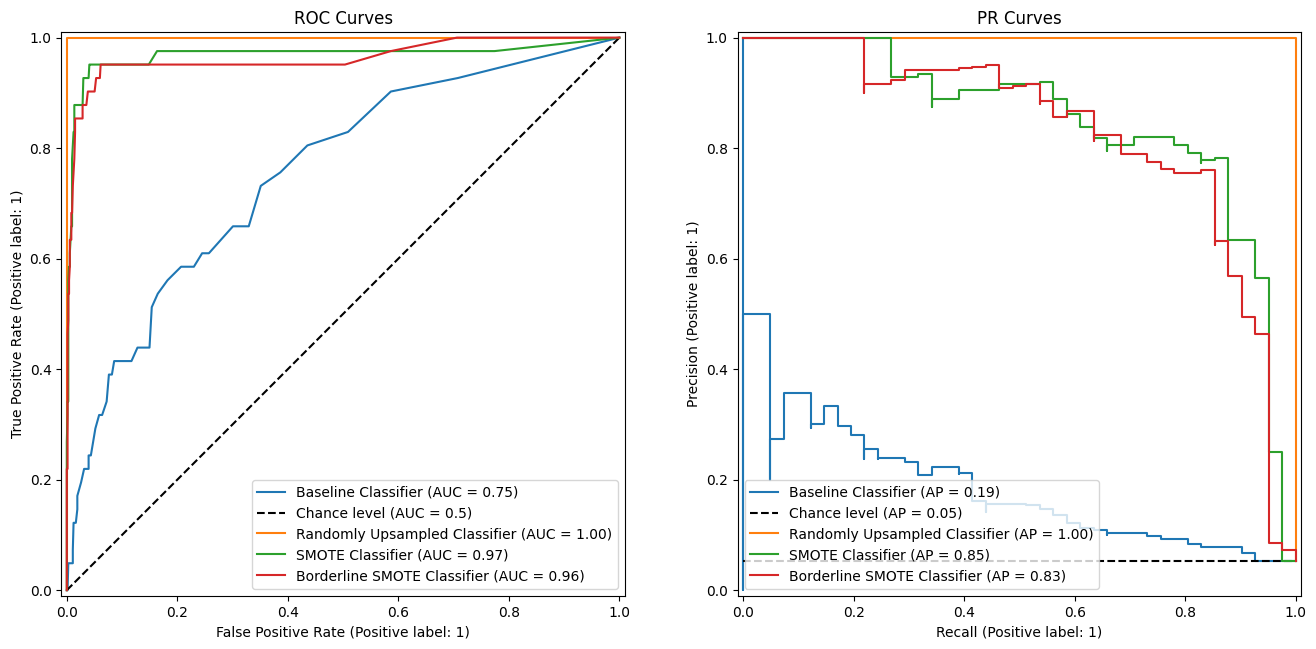

In [118]:
# Plotting all the ROC and PR Curves on top of each other
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot the baseline ROC Curve
metrics.RocCurveDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob, 
    pos_label=1,
    name='Baseline Classifier', 
    plot_chance_level=True,
    ax=axes[0]
)
# Plot the Randomly upsampled ROC Curve
metrics.RocCurveDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob_randup, 
    pos_label=1,
    name='Randomly Upsampled Classifier', 
    ax=axes[0]
)
# Plot the SMOTE ROC Curve
metrics.RocCurveDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob_SMOTE, 
    pos_label=1,
    name='SMOTE Classifier', 
    ax=axes[0]
)
# Plot the Borderline SMOTE ROC Curve
metrics.RocCurveDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob_BordSMOTE, 
    pos_label=1,
    name='Borderline SMOTE Classifier', 
    ax=axes[0]
)
# ========================================
# Plot the baseline PR Curve
metrics.PrecisionRecallDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob, 
    pos_label=1,
    name='Baseline Classifier', 
    plot_chance_level=True,
    ax=axes[1]
)
# Plot the Randomly upsampled PR Curve
metrics.PrecisionRecallDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob_randup, 
    pos_label=1,
    name='Randomly Upsampled Classifier', 
    ax=axes[1]
)
# Plot the SMOTE PR Curve
metrics.PrecisionRecallDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob_SMOTE, 
    pos_label=1,
    name='SMOTE Classifier', 
    ax=axes[1]
)
# Plot the Borderline SMOTE PR Curve
metrics.PrecisionRecallDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob_BordSMOTE, 
    pos_label=1,
    name='Borderline SMOTE Classifier', 
    ax=axes[1]
)

axes[0].set_title("ROC Curves")
axes[1].set_title("PR Curves")
plt.show()